Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mpich is already the newest version (4.0-3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Final temperatures:
[[ 0.   47.75 74.75 70.75 66.25 49.5  27.   36.75 47.5   0.  ]
 [ 0.   84.   65.25 68.75 63.75 42.5  50.5  54.   56.    0.  ]
 [ 0.   42.25 55.25 51.5  28.5  40.25 35.25 65.75 82.    0.  ]
 [ 0.   59.   51.25 22.5  32.25  9.   37.   47.5  54.75  0.  ]
 [ 0.   57.75 50.5  56.25 22.25 24.   25.5  58.75 34.75  0.  ]
 [ 0.   59.5  73.75 49.25 53.5  39.25 46.   36.   33.75  0.  ]
 [ 0.   58.25 46.   73.75 38.75 38.75 42.25 45.   32.    0.  ]
 [ 0.   41.5  41.5  44.5  40.75 32.   39.75 34.   27.25  0.  ]
 [ 0.   34.25 52.75 44.75 49.25 35.75 43.5  26.5  59.25  0.  ]
 [ 0.   57.25 48.25 63.   62.   53.75 38.75 49.25 39.5   0.  ]]


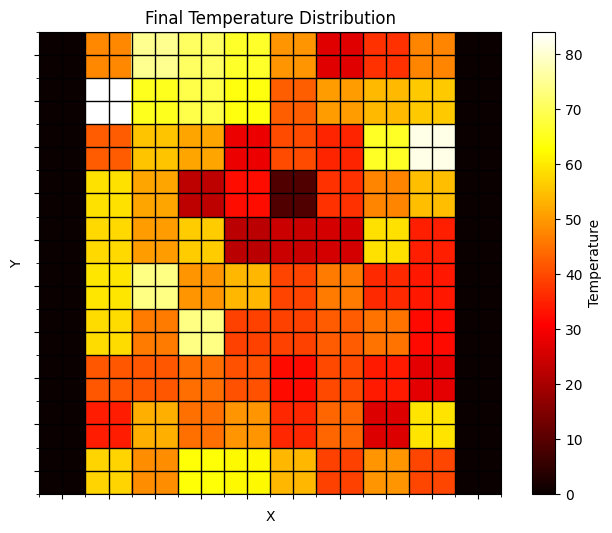

In [ ]:
!apt-get install mpich
!pip install mpi4py

from mpi4py import MPI
import numpy as np
import csv
import matplotlib.pyplot as plt

def read_dataset(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        data = list(reader)
        return np.array(data, dtype=float)

def visualize_simulation(final_temps):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Final Temperature Distribution')

    heatmap = ax.imshow(final_temps, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(heatmap)
    cbar.set_label('Temperature')

    ax.grid(which='both', color='black', linestyle='-', linewidth=1)
    ax.set_xticks(np.arange(-0.5, WIDTH, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, HEIGHT, 1), minor=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(0, WIDTH, 1))
    ax.set_yticks(np.arange(0, HEIGHT, 1))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()

WIDTH = 10
HEIGHT = 10
MAX_ITER = 100
EPSILON = 0.1

def simulate_heat_dissipation(rank, size, initial_temps):
    local_width = WIDTH // size
    temp_grid = initial_temps[:, rank * local_width : (rank + 1) * local_width]

    for _ in range(MAX_ITER):
        if rank < size - 1:
            MPI.COMM_WORLD.send(temp_grid[:, local_width - 1], dest=rank + 1, tag=rank)
        if rank > 0:
            temp_grid[:, 0] = MPI.COMM_WORLD.recv(source=rank - 1, tag=rank - 1)

        new_temp_grid = np.zeros_like(temp_grid)
        for i in range(HEIGHT):
            for j in range(1, local_width - 1):
                top_temp = temp_grid[i - 1, j] if i > 0 else temp_grid[i, j]
                bottom_temp = temp_grid[i + 1, j] if i < HEIGHT - 1 else temp_grid[i, j]
                new_temp_grid[i, j] = (temp_grid[i, j - 1] + temp_grid[i, j + 1] + top_temp + bottom_temp) / 4
        temp_grid = new_temp_grid

        if np.max(np.abs(temp_grid - new_temp_grid)) < EPSILON:
            break

    final_temps = MPI.COMM_WORLD.gather(temp_grid, root=0)
    if rank == 0:
        return final_temps


def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if rank == 0:
        temperatures = np.random.randint(0, 100, size=(HEIGHT, WIDTH))
        with open("temperature_dataset.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows(temperatures)

    comm.Barrier()

    dataset = read_dataset("temperature_dataset.csv")

    local_dataset = np.zeros((HEIGHT, WIDTH // size))
    comm.Scatter(dataset, local_dataset, root=0)

    final_temps = simulate_heat_dissipation(rank, size, local_dataset)

    if rank == 0:
        print("Final temperatures:")
        for temp_grid in final_temps:
            print(temp_grid)


        visualize_simulation(final_temps[0])

if __name__ == "__main__":
    main()
